In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [2]:
filename = 'D:\\Sandbox\\Github\\Data\\Frozen_Dessert_Production.csv'

In [3]:
df = pd.read_csv(filename, index_col='DATE', parse_dates=True)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [5]:
df.columns = ['Production']

In [120]:
df.tail()

,Production
DATE,
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632
2019-08-01,102.6085
2019-09-01,101.5866


<AxesSubplot:xlabel='DATE'>

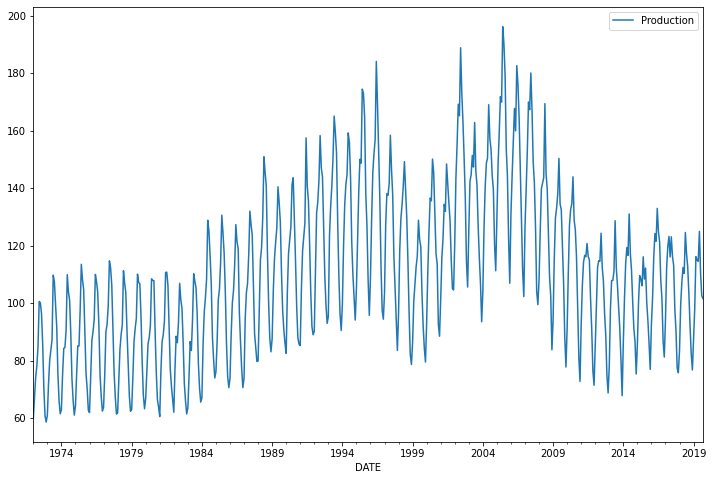

In [7]:
df.plot(figsize=(12,8))

In [8]:
len(df)

573

In [9]:
test_size = 24
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
len(test)

24

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAINING DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [15]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [19]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [21]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
early_stop = EarlyStopping(monitor='val_loss',patience=50)

In [24]:
# fit model
model.fit(generator,epochs=10,
          validation_data=validation_generator,
          callbacks=[early_stop])

Epoch 1/10
531/531 [==============================] - 5s 10ms/step - loss: 0.0302 - val_loss: 0.0058
Epoch 2/10
531/531 [==============================] - 4s 7ms/step - loss: 0.0109 - val_loss: 0.0017
Epoch 3/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 4/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 5/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 6/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 7/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0028 - val_loss: 0.0066
Epoch 8/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 9/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 10/10
531/531 [==============================] - 3s 6ms/step - loss: 0.0028 - val_loss: 0.002

<AxesSubplot:>

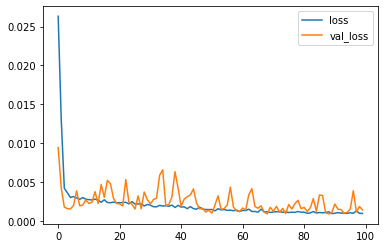

<AxesSubplot:>

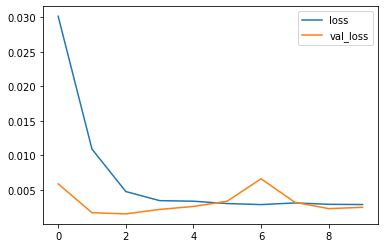

In [25]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [26]:
train_predictions = []

first_step = scaled_train[-length:]
current_step = first_step.reshape((1, length, n_features))

for i in range(len(train)):
    current_pred = model.predict(current_step)[0]
    train_predictions.append(current_pred) 
    current_step = np.append(current_step[:,1:,:], [[current_pred]], axis=1)

In [27]:
test_predictions = []

test_first_step = scaled_test[-length:]
test_current_step = test_first_step.reshape((1, length, n_features))

for i in range(len(test)):
    test_current_pred = model.predict(test_current_step)[0]
    test_predictions.append(test_current_pred) 
    test_current_step = np.append(test_current_step[:,1:,:], [[test_current_pred]], axis=1)

In [28]:
true_test_predictions = scaler.inverse_transform(test_predictions)

In [29]:
true_train_predictions = scaler.inverse_transform(train_predictions)

In [30]:
len(true_test_predictions)

24

In [31]:
len(true_train_predictions)

549

In [32]:
train.loc[:,'Predictions'] = true_train_predictions

C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [33]:
train.head(4)

,Production,Predictions
DATE,,
1972-01-01,59.9622,88.014418
1972-02-01,67.0605,83.819446
1972-03-01,74.2350,89.805965
1972-04-01,78.1120,101.540806


In [34]:
# test['Predictions'] = true_test_predictions

In [35]:
test.loc[:,'Predictions'] = true_test_predictions

C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [36]:
test.head(4)

,Production,Predictions
DATE,,
2017-10-01,90.4732,87.515905
2017-11-01,77.4378,83.010295
2017-12-01,75.8118,87.351935
2018-01-01,83.4343,97.591372


<AxesSubplot:xlabel='DATE'>

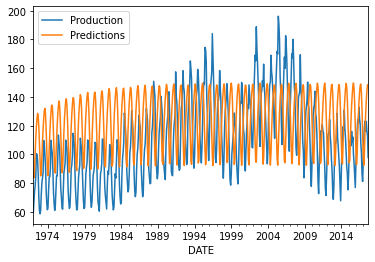

In [37]:
train.plot()

<AxesSubplot:xlabel='DATE'>

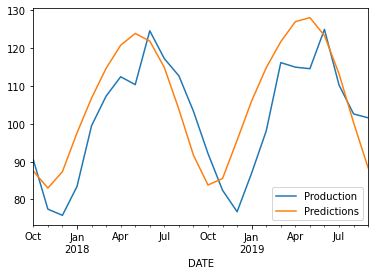

In [38]:
test.plot()

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
np.sqrt(mean_squared_error(train['Production'],train['Predictions']))

36.89646168044063

In [41]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

10.382998008101282

In [42]:
future_predictions = []

test_first_step = scaled_test[-length:]
test_current_step = test_first_step.reshape((1, length, n_features))

# predict next 12 months 
for i in range(36):
    test_current_pred = model.predict(test_current_step)[0]
    future_predictions.append(test_current_pred) 
    test_current_step = np.append(test_current_step[:,1:,:], [[test_current_pred]], axis=1)

In [43]:
len(future_predictions)

36

In [44]:
true_future_predictions = scaler.inverse_transform(future_predictions)

In [139]:
dates = pd.date_range('9/1/2019', periods=36, freq='M')

In [140]:
dates

DatetimeIndex(['2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31'],
              dtype='datetime64[ns]', freq='M')

In [148]:
df_future = pd.DataFrame(data=true_future_predictions, columns=['Future'],           
                         index=dates )

In [149]:
df_future

,Future
2019-09-30,87.515905
2019-10-31,83.010295
2019-11-30,87.351935
2019-12-31,97.591372
2020-01-31,106.797463
2020-02-29,114.659482
2020-03-31,120.764219
2020-04-30,123.881974
2020-05-31,121.860111
2020-06-30,114.879626


In [150]:
df_future = df_future.rename(columns = {'index':'DATE'})

In [151]:
df_future

,Future
2019-09-30,87.515905
2019-10-31,83.010295
2019-11-30,87.351935
2019-12-31,97.591372
2020-01-31,106.797463
2020-02-29,114.659482
2020-03-31,120.764219
2020-04-30,123.881974
2020-05-31,121.860111
2020-06-30,114.879626
